### http://solarisailab.com/archives/272
### https://laonple.blog.me/220880813236

# Autoencoder

### 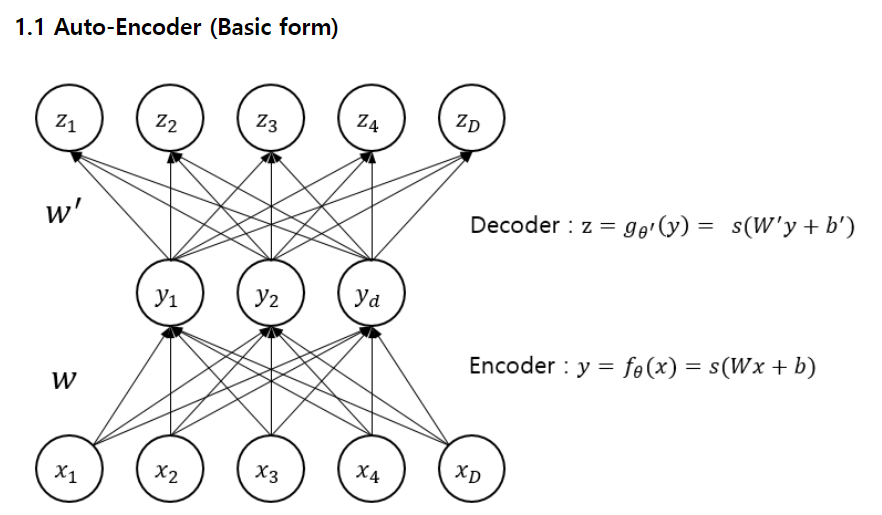

- 1. unsupervised learning

- 2. 출력 = 입력 만드는 hidden layer 만들기

- 3. by 차원 축소, noise 추가....

- 4. encoder(=recognition network) & decoder(=generative network) 로 구성

- 5. Undercomplete Autoencoder : hidden layer의 뉴런 수가, 입력/출력층보다 적은 경우! 중요한 feature 학습 가능

- 6. 활성화 함수로 linear를 사용할 경우, 그게 PCA임

- 7. Stacked Autoencoder : hidden layer를 여러개 가진 AE ( 주로 가운데 hidden layer기준으로 대칭인 구조! )

- 8. 가중치 묶기 : encoder & decoder의 가중치를 묶어준다 ( 대칭 기준으로! 그러면, 학흡해야할 parameter 줄어드므로 -> 학습 속도 up, overfitting down )

- 9. 한번에 한 층씩 학습하기( 그럴 경우, 훨씬 빠름 ) ( 그림(1) 참조 )

- 10. classification 사용 전에, 이용 가능! (비지도 사전학습) ( 그림 (2) 참조 )

- 11. Denoising AE : 가우시안 노이즈 추가! ( or Dropout도 가능 ) 

- 12. Sparse AE : 뉴런층의 일부만 활성화! ( NN의 Dropout과 유사! ) MSE보다 경사가 더 급한 KL-divergence ( 쿨백 라이블러 발산 ) 사용 ( 그림 (3) 참조 )

### (그림 1)
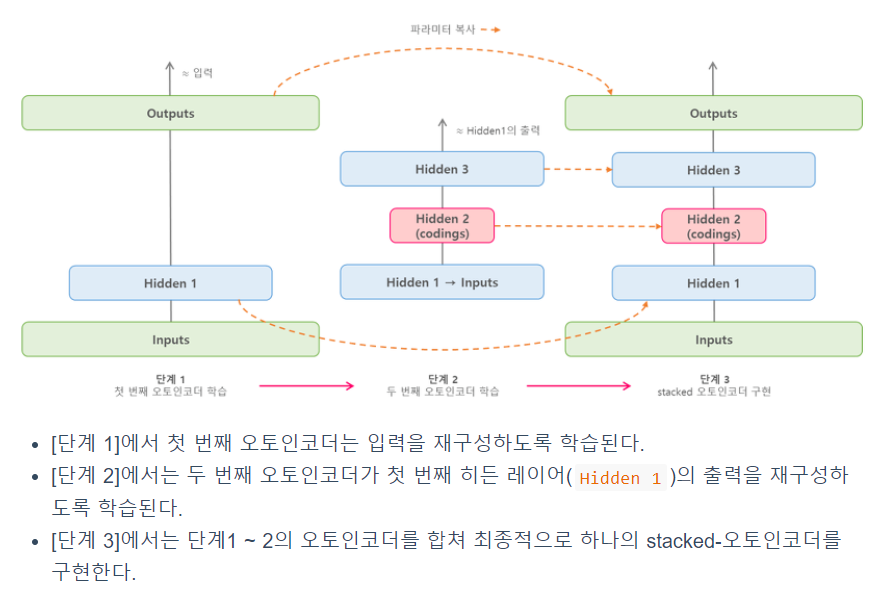

### (그림 2)
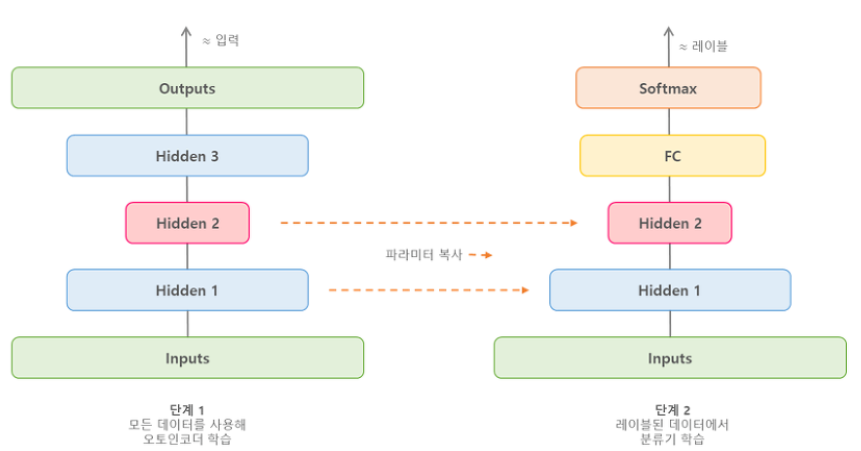

### (그림 3)
### 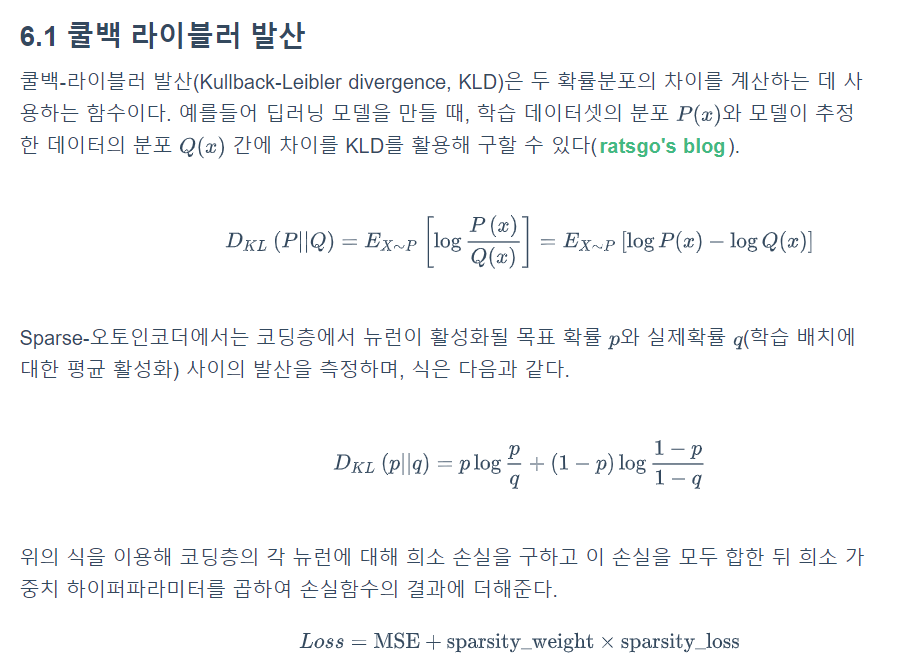

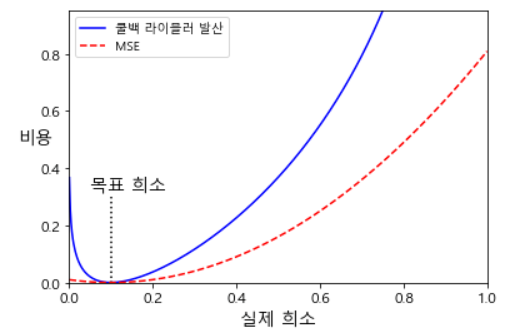

In [1]:
import tensorflow as tf

In [2]:
import numpy as np

### Encoder
- reduce data to lower dimension

In [3]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, inter_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(
            units=inter_dim,
            activation=tf.nn.relu,
            kernel_initializer='he_uniform' )
        self.output_layer = tf.keras.layers.Dense(
            units=inter_dim,
            activation=tf.nn.relu,
            kernel_initializer='he_uniform')
        
    def call(self,x):
        h = self.hidden_layer(x)
        z = self.output_layer(h)
        return z

### Decoder
- reconstructs the data from its lower dimension (z) to original data(x)

In [4]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, inter_dim, origin_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(
            units=inter_dim,
            activation=tf.nn.relu,
            kernel_initializer='he_uniform')
        self.output_layer = tf.keras.layers.Dense(
            units=origin_dim,
            activation=tf.nn.relu,
            kernel_initializer='he_uniform')        
        
        def call(self, z):
                activation = self.hidden_layer(z)
                origin = self.output_layer(activation)
                return origin

# Autoencoder

In [5]:
class Autoencoder(tf.keras.Model):
    def __init__(self, inter_dim, origin_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(inter_dim=inter_dim)
        self.decoder = Decoder(inter_dim=inter_dim, origin_dim=origin_dim)
        
    def call(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return reconstructed

### reconstruction error
- 마찬가지로 backpropagation
- 차이점은, x와 y가 아닌, x와 x hat을 비교!

In [13]:
def loss(model, original):
    recon_err = tf.reduce_mean(tf.square(tf.subtract(model,original)))
    return recon_err

In [7]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model,original), model.trainable_variables)
        grads = zip(gradients, model.trainable_variables)
        optimizer.apply_gradeints(grads)

### visualize training results by Tensorboard

In [8]:
ae = Autoencoder(inter_dim=64, origin_dim=784)
optimizer = tf.optimizers.Adam(learning_rate=0.01)

In [9]:
# batch size
bs =32
epoch = 100
step= 20

In [11]:
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
train_data = train_data / np.max(train_data)
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2])
train_data = train_data.astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.batch(bs)
train_dataset = train_dataset.shuffle(train_data.shape[0])
train_dataset = train_dataset.prefetch(bs*4)

writer = tf.summary.create_file_writer('tmp')

In [14]:
with writer.as_default():
    with tf.summary.record_if(True):
        for epoch in range(epoch):
            for step, batch in enumerate(train_dataset):
                # train하기
                train(loss,ae, optimizer, batch)
                
                # loss
                loss_values = loss(ae,batch)                
                # 원본
                original = tf.reshape(batch, (batch.shape[0],28,28,1))
                # 재구성
                reconstructed = tf.reshape(ae(tf.constant(batch)),(batch.shape[0],28,28,1))
                
                tf.summary.scalar('loss',loss_values, step=step)
                tf.summary.image('original', original, max_outputs=10, step=step)
                tf.summary.image('reconstructed', reconstructed, max_outputs-10, step=stp)

In [17]:
import os
from datetime import datetime

%load_ext tensorboard
%matplotlib inline

In [18]:
logdir = os.path.join('logs',  datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir

'logs\\20191018-180120'

In [19]:
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, 
    write_graph=True, 
    write_images=True,
    histogram_freq=1
)

In [22]:
%tensorboard --logdir logs --port 4003

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "C:\Users\samsung\Anaconda3\Scripts\tensorboard-script.py", line 10, in <module>
    sys.exit(run_main())
  File "C:\Users\samsung\Anaconda3\lib\site-packages\tensorboard\main.py", line 64, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "C:\Users\samsung\Anaconda3\lib\site-packages\absl\app.py", line 299, in run
    _run_main(main, args)
  File "C:\Users\samsung\Anaconda3\lib\site-packages\absl\app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "C:\Users\samsung\Anaconda3\lib\site-packages\tensorboard\program.py", line 228, in main
    server = self._make_server()
  File "C:\Users\samsung\Anaconda3\lib\site-packages\tensorboard\program.py", line 309, in _make_server
    self.assets_zip_provider)
  File "C:\Users\samsung\Anaconda3\lib\site-packages\tensorboard\backend\application.py", line 161, in standard_tensorboard_wsgi
